# binary classification: crack vs no crack

### unzip the data

In [3]:
import os
os.chdir("./")
!cd

D:\JupyterNotebook\dar9kor\bridge_crack


In [4]:
from zipfile import ZipFile

# opening the zip file in READ mode 
with ZipFile("ml.zip", 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')

Extracting all the files now...
Done!


In [5]:
#!ls
%ls

 Volume in drive D is Second Disk
 Volume Serial Number is 504B-065A

 Directory of D:\JupyterNotebook\dar9kor\bridge_crack

03/24/2020  05:21 PM    <DIR>          .
03/24/2020  05:21 PM    <DIR>          ..
03/24/2020  05:02 PM    <DIR>          .ipynb_checkpoints
03/24/2020  05:16 PM             7,790 bridge_crack_val20_GPU.ipynb
03/24/2020  05:21 PM    <DIR>          ml
03/24/2020  04:55 PM       252,191,434 ml.zip
               2 File(s)    252,199,224 bytes
               4 Dir(s)  969,716,494,336 bytes free


### check the images

In [1]:
import pathlib
from PIL import Image
import pandas as pd

def get_image_spec(im_paths):
    path_sorted = sorted([x for x in im_paths])
    all_mode = []
    
    for idx in range(len(path_sorted)):
        im_path = path_sorted[idx]
        img = Image.open(im_path)
        width, height = img.size
        m = img.mode
        #all_size[str(width) + '_' + str(height)] = ''  # saving height width as keys of dict
        all_mode.append([im_path,m, width, height])
        
    all_mode = pd.DataFrame(all_mode, columns=['path','mode', 'width','height'])
    return all_mode

In [2]:
# check image size

im_paths = pathlib.Path('./ml/').glob('*/*/*')
image_data = get_image_spec(im_paths)
image_data.shape

(12000, 4)

In [3]:
# create a df with unique width & height,
df = image_data.drop_duplicates(['width','height'])
df

,path,mode,width,height
0,ml\train\crack\crack1.jpeg,RGB,16,16


In [4]:
image_data.drop_duplicates(['mode'])

,path,mode,width,height
0,ml\train\crack\crack1.jpeg,RGB,16,16


### model building

In [1]:
# auto-updating
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import fastai
import time
from fastai.vision import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# GradCAM
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

class GradCam():
    @classmethod
    def from_interp(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        # produce heatmap and xb_grad for pred label (and actual label if include_label is True)
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.preds[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item() # get class idx of img prediction label
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        actual_args=None
        if include_label:
            actual_idx = ds.y.items[img_idx] # get class idx of img actual label
            if actual_idx!=pred_idx:
                hmap_actual,xb_grad_actual = get_grad_heatmap(learn,xb,actual_idx,size=xb_img.shape[-1])
                prob_actual = probs[actual_idx]
                actual_args=[interp.data.classes[actual_idx],prob_actual,hmap_actual,xb_grad_actual]
        
        return cls(xb_img,interp.data.classes[pred_idx],prob_pred,hmap_pred,xb_grad_pred,actual_args)
    
    @classmethod
    def from_one_img(cls,learn,x_img,label1=None,label2=None):
        '''
        learn: fastai's Learner
        x_img: fastai.vision.image.Image
        label1: generate heatmap according to this label. If None, this wil be the label with highest probability from the model
        label2: generate additional heatmap according to this label
        '''
        pred_class,pred_idx,probs = learn.predict(x_img)
        label1= str(pred_class) if not label1 else label1
        
        xb,_ = learn.data.one_item(x_img)
        xb_img = Image(learn.data.denorm(xb)[0])
        probs = probs.numpy()
        
        label1_idx = learn.data.classes.index(label1)
        hmap1,xb_grad1 = get_grad_heatmap(learn,xb,label1_idx,size=xb_img.shape[-1])
        prob1 = probs[label1_idx]
        
        label2_args = None
        if label2:
            label2_idx = learn.data.classes.index(label2)
            hmap2,xb_grad2 = get_grad_heatmap(learn,xb,label2_idx,size=xb_img.shape[-1])
            prob2 = probs[label2_idx]
            label2_args = [label2,prob2,hmap2,xb_grad2]
            
        return cls(xb_img,label1,prob1,hmap1,xb_grad1,label2_args)
    
    def __init__(self,xb_img,label1,prob1,hmap1,xb_grad1,label2_args=None):
        self.xb_img=xb_img
        self.label1,self.prob1,self.hmap1,self.xb_grad1 = label1,prob1,hmap1,xb_grad1
        if label2_args:
            self.label2,self.prob2,self.hmap2,self.xb_grad2 = label2_args
            
    def plot(self,plot_hm=True,plot_gbp=True):
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'label2') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'label2') else 1

        fig,row_axes = plt.subplots(1,cols,figsize=(cols*5,5))  
        col=0
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        
        label1_title = f'1.{self.label1} {self.prob1:.3f}'
        if plot_hm:
            show_heatmap(self.hmap1,self.xb_img,size,row_axes[col])
            row_axes[col].set_title(label1_title);col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad1)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(label1_title);col+=1
        
        if hasattr(self, 'label2'):
            label2_title = f'2.{self.label2} {self.prob2:.3f}'
            if plot_hm:
                show_heatmap(self.hmap2,self.xb_img,size,row_axes[col])
                row_axes[col].set_title(label2_title);col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad2)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(label2_title)
        # plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        # fig.savefig('data_draw/both/gradcam.png')

def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

# hook for Gradcam
def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: #hook at last layer of group 0's output (after bn, size 512x7x7 if resnet34)
        with hook_output(target_layer, grad=True) as hook_g: # gradient w.r.t to the target_layer
            preds = m(xb)
            preds[0,int(clas)].backward() # same as onehot backprop
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
        
# hook for guided backprop
def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "ReLU(inplace)"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
        
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,size,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bilinear',cmap='magma');

def get_grad_heatmap(learn,xb,y,size):
    '''
    Main function to get hmap for heatmap and xb_grad for guided backprop
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[0][-1][-1] # last layer of group 0
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
#     hmap = (target_act*mean_grad[...,None,None]).mean(0)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiply xb_grad and hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [5]:
## set params

# Set batch size of images 
bs = 32  #64

# set paths
image_path = Path("D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/")  #("/content/gdrive/My Drive/Bridge_Crack_Image_Data-master/train_final/")
model_save_path = Path("D:/JupyterNotebook/dar9kor/bridge_crack/ml/models/")  #("/content/gdrive/My Drive/Bridge_Crack_Image_Data-master/trained_model/")

image_path.ls()


[WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/crack'),
 WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/no_crack')]

In [6]:
# numpy, torch, random, etc
def random_seed(seed_value, use_cuda):  
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True

    if use_cuda: torch.cuda.manual_seed_all(seed_value) 

# Set seed
#random_seed(0,False)
random_seed(0,True)

In [7]:
## load data
# fastai is automatically supposed to handle image format conversions- greyscale(L), RGB

# https://forums.fast.ai/t/how-to-load-images-as-grayscale/36895/6
# google: can fastai convert greyscale images to RGB

data = ImageDataBunch.from_folder(image_path, 
                                  valid_pct=0.20,
                                  ds_tfms=get_transforms(), 
                                  size=224, 
                                  bs=bs, 
                                  num_workers=1,
                                  seed=0).normalize(imagenet_stats)

In [8]:
data

ImageDataBunch;

Train: LabelList (9600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
crack,crack,crack,crack,crack
Path: D:\JupyterNotebook\dar9kor\bridge_crack\ml\train;

Valid: LabelList (2400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
crack,no_crack,no_crack,no_crack,no_crack
Path: D:\JupyterNotebook\dar9kor\bridge_crack\ml\train;

Test: None

In [9]:
data.classes
data.c
len(data.train_ds)
len(data.valid_ds)

['crack', 'no_crack']

2

9600

2400

In [10]:
# count no. of examples in train & validation sets 
# train set
vc = pd.value_counts(data.train_ds.y.items, sort =False)
vc.index = data.classes
vc
# ratio

crack       4817
no_crack    4783
dtype: int64

In [11]:
# val set
vc = pd.value_counts(data.valid_ds.y.items, sort =False)
vc.index = data.classes
vc
# ratio

crack       1183
no_crack    1217
dtype: int64

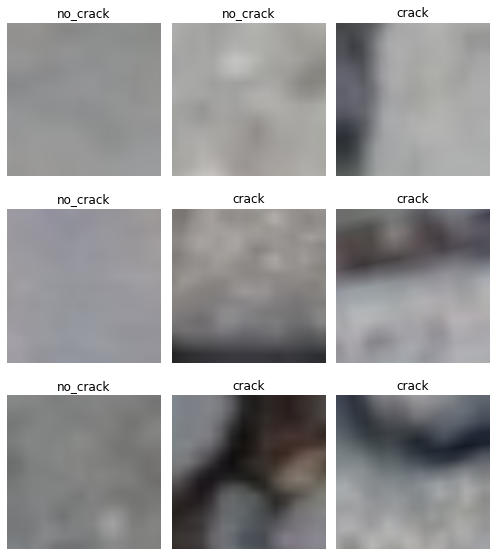

In [12]:
data.show_batch(rows=3, figsize=(7,8))
#data.show_batch(rows=3, figsize=(10,10), ds_type=DatasetType.Valid)
#data.show_batch(rows=3, figsize=(10,10), ds_type=DatasetType.Train)

##  #### Model building: STAGE 1

In [13]:
from torchvision.models import resnet34      #resnet50

precision = Precision()
recall = Recall()
metrics = [accuracy,precision,recall]
learn = cnn_learner(data, resnet34, pretrained=True, metrics=metrics)

In [15]:
## trying to add other metrics
# https://forums.fast.ai/t/f1-score-as-metric/30370/26
# https://forums.fast.ai/t/precision-recall-understanding-averages/41019
# https://forums.fast.ai/t/understanding-metrics-and-callbacks/28172

# http://dev.fast.ai/metrics
# there is another page of metrics under docs, & definitions are different - why?


In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [14]:
print(datetime.now())

2020-03-25 00:09:41.653967


In [15]:
# learn with default model + extra 1 layer
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.181524,0.068821,0.978333,0.970897,0.986853,01:52
1,0.086783,0.039985,0.990000,0.986939,0.993426,01:49
2,0.091688,0.031785,0.990417,0.990954,0.990140,01:50
3,0.049971,0.031320,0.990833,0.990156,0.991783,01:49


In [16]:
print(datetime.now())

2020-03-25 00:17:04.141278


In [17]:
# save the basic Resnet34 model
learn.save('resnet34_epc4_val20_stage-1')  
learn.export(model_save_path/'resnet34_epc4_val20_stage-1.pkl')

In [ ]:
####  model performance : stage 1

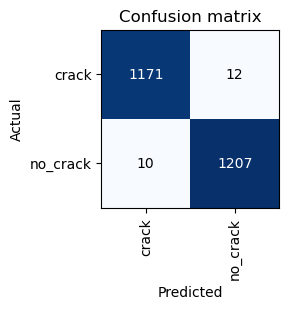

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [19]:
interp.most_confused()

[('crack', 'no_crack', 12), ('no_crack', 'crack', 10)]

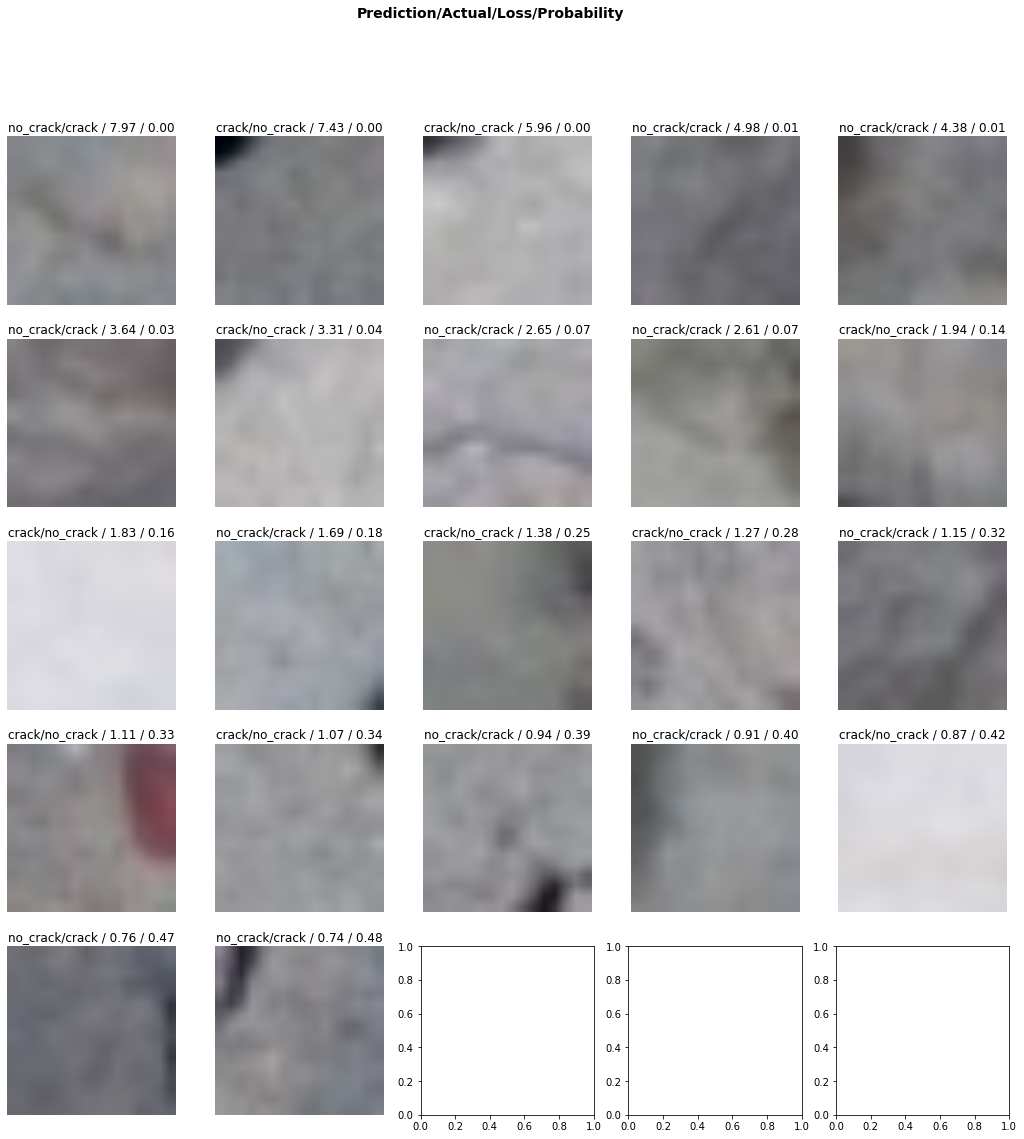

In [20]:
# plot images with the highest loss (biggest mistake)
interp.plot_top_losses(22, figsize=(18,18))
# interp.plot_top_losses(9,heatmap=True, figsize=(7,8))

In [21]:
# find wrongly predicted images
# https://forums.fast.ai/t/path-of-images-corresponding-to-top-losses/30506

#interp.top_losses(9)
losses,idxs = interp.top_losses(22)   # indices of wrongly predicted images
data.valid_ds.x.items[idxs]

array([WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/crack/crack99.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/no_crack/no5515.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/no_crack/no5738.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/crack/crack1124.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/crack/crack258.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/crack/crack679.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/no_crack/no5731.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/crack/crack2149.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/crack/crack2020.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/no_crack/no2033.jpeg'),
       WindowsPath('D:/JupyterNotebook/dar9kor/bridge_crack/ml/train/no_cr

In [22]:
idxs

tensor([ 264, 1716, 1428, 1185, 1458,  379, 1630, 2066,  961,  287,  602,  219,
        1330, 1580, 1341,  224,  838,  790, 1833, 1965,  658, 2233])

crack


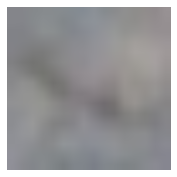

In [23]:
# run GradCAM on 1st image
x,y=data.valid_ds[264]  # put correct index here, from "idxs"
x.show()
print(y)

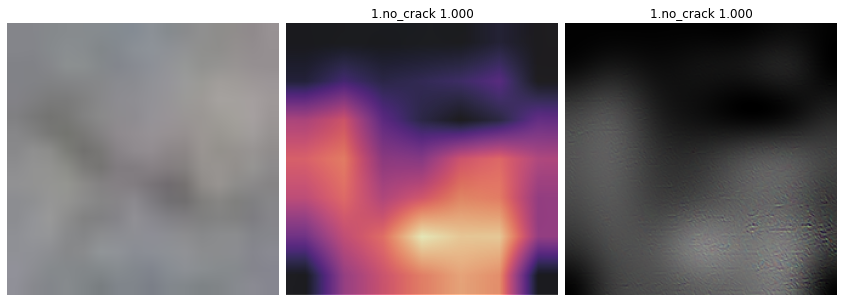

In [24]:
img = x
gcam = GradCam.from_one_img(learn,img)
gcam.plot()

no_crack


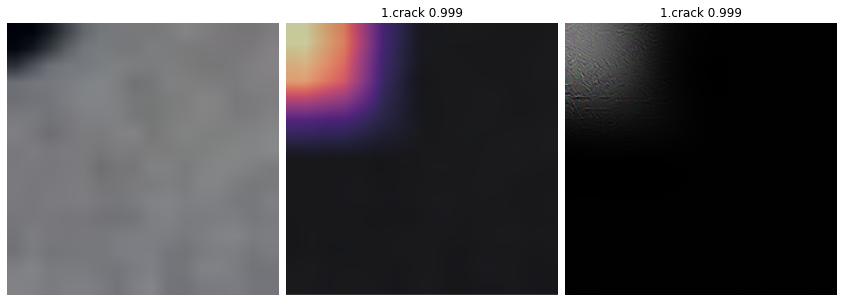

In [25]:
# 2nd image
x,y=data.valid_ds[1716]
print(y)
img = x
gcam = GradCam.from_one_img(learn,img)
gcam.plot()
# why is it not focusing on the region that has the crack?

## ##### model training: stage 2

In [26]:
## unfreezing & training all layers
learn.unfreeze()

In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.111819,0.065067,0.976667,0.991533,0.962202,01:55
1,0.069432,0.040888,0.989583,0.986928,0.992605,01:55
2,0.039410,0.028361,0.991250,0.992586,0.990140,01:55
3,0.036953,0.024366,0.992500,0.991797,0.993426,01:55


In [28]:
learn.export(model_save_path/'resnet34_epc4_val20_stage-2.pkl')
#learn.save(os.path.join(model_save_path,'/resnet34_nocrk6000_epc2_stage-2'))
learn.save('resnet34_epc4_val20_stage-2')

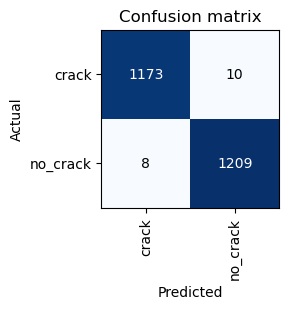

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)  # wrong predictions for crack reduce at the cost of no crack

AttributeError: 'Learner' object has no attribute 'losses'

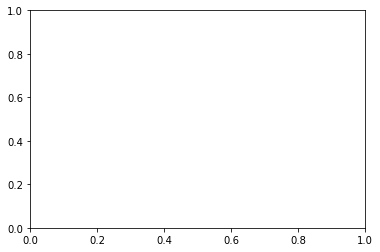

In [34]:
learn.recorder.plot_losses()

In [40]:
learn.load('resnet34_epc4_val20_stage-1');

In [41]:
learn.unfreeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.106547,0.040007,0.985833,0.978947,0.993426,01:54
1,0.081403,0.046649,0.987083,0.981331,0.993426,01:54
2,0.053251,0.028562,0.990417,0.990148,0.990961,01:55
3,0.034699,0.025961,0.992083,0.995861,0.988496,01:55


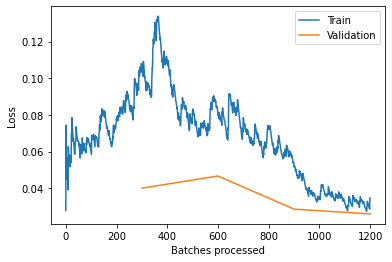

In [42]:
learn.recorder.plot_losses()
# thisworks if 
#     i. model is loaded with ''
#    ii. load statement ends with ;

In [44]:
# seeing doc string
doc(learn.recorder.plot_losses)

## #### model training: stage 3

In [35]:
## unfreeze & train with changing learning rates
# we will re-load the previously built model (resnet34), & try some more epochs
# especially if stage 2 shows similar or slightly worse performance to previous model?

learn.load("resnet34_epc4_val20_stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (9600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
crack,crack,crack,crack,crack
Path: D:\JupyterNotebook\dar9kor\bridge_crack\ml\train;

Valid: LabelList (2400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
crack,no_crack,no_crack,no_crack,no_crack
Path: D:\JupyterNotebook\dar9kor\bridge_crack\ml\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [37]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Failed to compute the gradients, there might not be enough points.


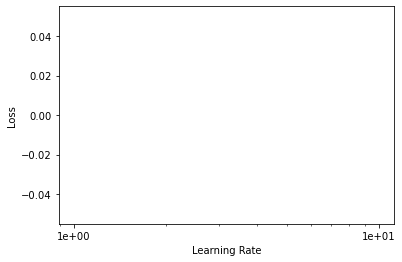

In [38]:
learn.recorder.plot(suggestion=True)

In [45]:
learn.load('resnet34_epc4_val20_stage-1');

In [46]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Failed to compute the gradients, there might not be enough points.


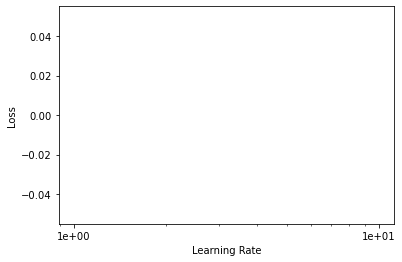

In [47]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.unfreeze()
#learn.fit_one_cycle(4)
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.export(model_save_path/'resnet34_nocrk6000_epc2_stage-3.pkl')
#learn.save(os.path.join(model_save_path,'/resnet34_nocrk6000_epc2_stage-3'))
learn.save('resnet34_nocrk6000_epc2_stage-3')

In [ ]:
## model interpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)  # wrong predictions for crack reduce at the cost of no crack

In [ ]:
learn.recorder.plot_losses()

## #### CHECK PERFORMANCE ON NEW IMAGES

In [48]:
# level 3 model
#learn = load_learner(model_save_path, "resnet34_epc2_stage-1.pkl")
#learn = load_learner(model_save_path, "resnet34_nocrk6000_epc2_stage-3.pkl")

# level 1 model
learn.load('resnet34_epc4_val20_stage-1');

In [ ]:
'''# predicting on a separate set, with labeled data
# this method can be used only if the test images are directly in the "test" directory


test_directory = '/content/gdrive/My Drive/Bridge_Crack_Image_Data-master/test/'
# need to use single quotes in the above command; double quote gave I/O error

images = os.listdir(test_directory)

from fastai.vision import image
pred = []

for i in images:
    img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    pred_class,pred_idx,outputs = learn.predict(img)
    pred.append(str(pred_class))
'''

In [49]:
# predicting on a separate set, with labeled data
# use this method if there are several folders withing test folder
test_directory = './ml/test/'   #'/content/gdrive/My Drive/Bridge_Crack_Image_Data-master/test/'
images = []

for r, d, f in os.walk(test_directory):
    for file in f:
        #if file.endswith(".docx"):
        images.append(os.path.join(r, file))


In [50]:
images

['./ml/test/crack1.jpeg',
 './ml/test/crack10.jpeg',
 './ml/test/crack100.jpeg',
 './ml/test/crack101.jpeg',
 './ml/test/crack102.jpeg',
 './ml/test/crack103.jpeg',
 './ml/test/crack104.jpeg',
 './ml/test/crack105.jpeg',
 './ml/test/crack106.jpeg',
 './ml/test/crack107.jpeg',
 './ml/test/crack108.jpeg',
 './ml/test/crack109.jpeg',
 './ml/test/crack11.jpeg',
 './ml/test/crack110.jpeg',
 './ml/test/crack111.jpeg',
 './ml/test/crack112.jpeg',
 './ml/test/crack113.jpeg',
 './ml/test/crack114.jpeg',
 './ml/test/crack115.jpeg',
 './ml/test/crack116.jpeg',
 './ml/test/crack117.jpeg',
 './ml/test/crack118.jpeg',
 './ml/test/crack119.jpeg',
 './ml/test/crack12.jpeg',
 './ml/test/crack120.jpeg',
 './ml/test/crack121.jpeg',
 './ml/test/crack122.jpeg',
 './ml/test/crack123.jpeg',
 './ml/test/crack124.jpeg',
 './ml/test/crack125.jpeg',
 './ml/test/crack126.jpeg',
 './ml/test/crack127.jpeg',
 './ml/test/crack128.jpeg',
 './ml/test/crack129.jpeg',
 './ml/test/crack13.jpeg',
 './ml/test/crack130.jpeg'

In [51]:
from fastai.vision import image
pred = []

# check timestamp at start & end of predictions
#print(datetime.now())
start_time = datetime.now()

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    pred_class,pred_idx,outputs = learn.predict(img)
    pred.append(str(pred_class))

end_time = datetime.now()
#print(datetime.now())

In [52]:
print(start_time)
print(end_time)

2020-03-25 01:28:04.710658
2020-03-25 01:28:11.958268


In [53]:
#(end_time - start_time).total_seconds()/450
(end_time - start_time).total_seconds()/len(pred)

0.0161058

In [54]:
actual = []

for item in images:   # can be used if images are in sub-folders within test
#for item in os.listdir(test_directory):  # only when images are directly in "test"
    if 'no' in item:
        actual.append('no_crack')
    if 'crack' in item:
        actual.append('crack')

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class_names = ['crack','no_crack']
print(classification_report(actual, pred, target_names=class_names))

              precision    recall  f1-score   support

       crack       0.99      0.99      0.99       150
    no_crack       1.00      0.99      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [56]:
accuracy_score(actual, pred)

0.9933333333333333

In [57]:
confusion_matrix(actual,pred,labels=class_names)

array([[149,   1],
       [  2, 298]], dtype=int64)

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[149   1]
 [  2 298]]


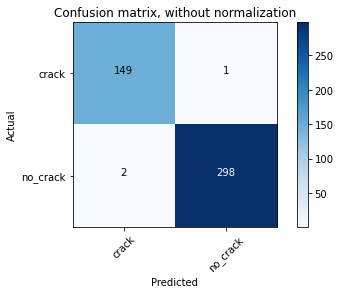

In [58]:
cnf_matrix = confusion_matrix(actual, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


## ##### Checking prediction time

In [59]:
# how to check prediction time : how many images is this checking on?

%timeit pred_class,pred_idx,outputs = learn.predict(img)

15.6 ms Â± 261 Âµs per loop (mean Â± std. dev. of 7 runs, 100 loops each)
